In [10]:
# Configuration step
import numpy as np
import matplotlib.pyplot as plt

# Show the plots in the Notebook.
plt.switch_backend("nbagg")

In [11]:
# Functions

# Left boundary
def BC0(u,v,r,rho,mu,U,V):
    cs = np.sqrt(mu/rho) 
    Zs = rho*cs
    g = 1.0 * (0.5*Zs*(1-r)*U - 0.5*(1+r)*V)
    p = 0.5 * (Zs*u + v)
    BCu = (1+r)/Zs * p + 1/Zs * g
    BCv = (1-r)*p - g
    return {'BCu':BCu,'BCv':BCv}

# Right boundary
def BCn(u,v,r,rho,mu,U,V):
    cs = np.sqrt(mu/rho)
    Zs = rho * cs
    
    f = 1.0 * (0.5*Zs*(1-r)*U + 0.5 *(1+r)*V)
    q = 0.5 * (Zs * u -v)
    
    BCu = (1+r)/Zs * q + 1/Zs * f
    BCv = -(1-r)*q + f
    return {'BCu':BCu,'BCv':BCv}

def Dx(u,D,NP,num_element,dx):
    ux = np.zeros(len(u))
    
    for j in range (1,num_element+1):
        ux[(j-1)*NP:NP+(j-1)*NP] = 2/dx[j-1] *(D.dot(u[(j-1)*NP:NP+(j-1)*NP]))
    return ux

# derivative of the polynomials
def alternative_dl(j,x,z):
    y = 0
    n = len(x)
    for l in range(1,n+1):
        if l != j:
            k = 1/(x[j-1]-x[l-1])
            for m in range(1,n+1):
                if (m!=j) and (m!=l):
                    k = k *(z-x[m-1])/(x[j-1]-x[m-1])
            y = y + k
    return y

def lagrange_basis(NP,i,x,xi):
    h = 1.;
    for j in range(1,NP+1):
        if (j != i): 
            num = x - xi[j-1]
            den = xi[i-1]-xi[j-1]
            h = h * num/den 
    return h

def interpol(NP,x,xi,f):
    g = 0.
    for i in range(1,NP+1):
        a_i = lagrange_basis(NP,i,x,xi)
        g = g + a_i * f[i-1]
    return g

def interface_condition(v_m,t_m,v_p,t_p,rho_m,mu_m,rho_p,mu_p):
    cs_m = np.sqrt(mu_m/rho_m)
    cs_p = np.sqrt(mu_p/rho_p)
    Zs_m = rho_m * cs_m
    Zs_p = rho_p * cs_p
    
    q_m = Zs_m * v_m - t_m
    p_p = Zs_p * v_p + t_p
    eta_s = Zs_m * Zs_p/(Zs_m + Zs_p)
    Phi = eta_s * (1.0/Zs_p * p_p - 1.0/Zs_m * q_m)
    vv = 0.0 
    T_m = Phi
    T_p = Phi
    V_p = (q_m + T_m)/Zs_m + vv
    V_m = (p_p - T_p)/Zs_p - vv
    return {'V_m':V_m, 'V_p':V_p, 'T_m':T_m, 'T_p':T_p}

def friction_law(v_m,t_m,v_p,t_p,S,rho_m,mu_m,rho_p,mu_p,alpha):
    cs_m = np.sqrt(mu_m/rho_m)
    cs_p = np.sqrt(mu_p/rho_p)
    Zs_m = rho_m * cs_m
    Zs_p = rho_p * cs_p
    
    q_m = Zs_m * v_m - t_m
    p_p = Zs_p * v_p + t_p
    eta_s = Zs_m * Zs_p/(Zs_m + Zs_p)
    Phi = eta_s * (1.0/Zs_p * p_p - 1.0/Zs_m * q_m)
    Tau_lock = Phi + Tau_0
    
    if friction_type == 'linear': 
        vv = Phi/(alpha+eta_s)
        
        T_m = alpha/(alpha+eta_s)*Phi
        T_p = T_m
        
    elif friction_type == 'slip weakening':
        Tau_str = TauStrength(S)
 
        if Tau_lock >= Tau_str: #fault sliping
            slip_weakening_return = slip_weakening(Phi,Tau_0, Tau_str, eta_s)
            Tau_h = slip_weakening_return['Tau_h']
            vv = slip_weakening_return['vv']
    
            T_m = Tau_h - Tau_0 
            T_p = Tau_h - Tau_0 
            V_p = (q_m + T_m)/Zs_m + vv
            V_m = (p_p - T_p)/Zs_p - vv
        
        else: #fault locked 
            vv = 0
            T_m = Phi
            T_p = Phi
    else:
        raise NotImplementedError
    
    V_p = (q_m + T_m)/Zs_m + vv
    V_m = (p_p - T_p)/Zs_p - vv
    return {'V_m':V_m, 'V_p':V_p, 'T_m':T_m, 'T_p':T_p}

# FUNCTION GL points
# Returns GL points and weights
def GL(N):
    
    if (N == 1):
        x = [-1.0/3*sqrt(3), 1.0/3*sqrt(3)];
        w = [1, 1];
        
    if (N == 2):
        x = [-1.0/5*sqrt(15), 0, 1.0/5*sqrt(15)];
        w = [5/9, 8/9, 5/9];
    
    if (N == 3):
        x = [-1/(35)*sqrt(525+70*sqrt(30)), -1/(35)*sqrt(525-70*sqrt(30)), 1/(35)*sqrt(525-70*sqrt(30)), 1/(35)*sqrt(525+70*sqrt(30))];
        w = [1/(36)*(18-sqrt(30)), 1/(36)*(18+sqrt(30)), 1/(36)*(18+sqrt(30)), 1/(36)*(18-sqrt(30))];
    if (N == 4):
        x = [-1/(21)*sqrt(245+14*sqrt(70)), -1/(21)*sqrt(245-14*sqrt(70)), 0, 1/(21)*sqrt(245-14*sqrt(70)), 1/(21)*sqrt(245+14*sqrt(70))];
        w = [1/(900)*(322-13*sqrt(70)), 1/(900)*(322+13*sqrt(70)), (128)/(225), 1/(900)*(322+13*sqrt(70)), 1/(900)*(322-13*sqrt(70))];
    if (N == 5):
        x=[-0.93246951420315, -0.66120938646626, -0.23861918608320, 0.23861918608320, 0.66120938646626, 0.93246951420315];
        w= [0.17132449237917, 0.36076157304814, 0.46791393457269, 0.46791393457269, 0.36076157304814, 0.17132449237917];
    if (N == 6):
        x=[-0.94910791234276, -0.74153118559939, -0.40584515137740, 0.00000000000000, 0.40584515137740, 0.74153118559939, 0.94910791234276];
        w = [0.12948496616887, 0.27970539148928, 0.38183005050512, 0.41795918367347, 0.38183005050512, 0.27970539148928, 0.12948496616887];
    if (N == 7):
        x=[-0.96028985649754, -0.79666647741363, -0.52553240991633, -0.18343464249565, 0.18343464249565, 0.52553240991633, 0.79666647741363, 0.96028985649754];
        w =[0.10122853629038, 0.22238103445337, 0.31370664587789, 0.36268378337836, 0.36268378337836, 0.31370664587789, 0.22238103445337, 0.10122853629038];
    return {'x':x,'w':w}

# FUNCTION gll points
# Returns gll (Gauss-Lobato-Legendre) collocation points and weights
def gll(N):
    if N == 2:
        xi = [-1.0, 0.0, 1.0];
        weights = [0.33333333, 1.33333333, 0.33333333];
    if N == 3:
        xi = [-1.0, -0.447213595499957, 0.447213595499957, 1.0];
        weights = [0.1666666667, 0.833333333, 0.833333333, 0.1666666666];
    if N == 4:
        xi = [-1.0, -0.6546536707079772, 0.0, 0.6546536707079772, 1.0];
        weights = [0.1, 0.544444444, 0.711111111, 0.544444444, 0.1];
    if N == 5:
        xi = [-1.0, -0.7650553239294647, -0.285231516480645, 0.285231516480645,\
              0.7650553239294647, 1.0];
        weights = [0.0666666666666667,  0.3784749562978470,\
                   0.5548583770354862, 0.5548583770354862, 0.3784749562978470,\
                   0.0666666666666667];
    if N == 6:
        xi = [-1.0, -0.8302238962785670, -0.4688487934707142, 0.0,\
              0.4688487934707142, 0.8302238962785670, 1.0];
        weights = [0.0476190476190476, 0.2768260473615659, 0.4317453812098627,\
                   0.4876190476190476, 0.4317453812098627, 0.2768260473615659,\
                   0.0476190476190476];
    if N == 7:
        xi = [-1.0, -0.8717401485096066, -0.5917001814331423,\
              -0.2092992179024789, 0.2092992179024789, 0.5917001814331423,\
              0.8717401485096066, 1.0];
        weights = [0.0357142857142857, 0.2107042271435061, 0.3411226924835044,\
                   0.4124587946587038, 0.4124587946587038, 0.3411226924835044,\
                   0.2107042271435061, 0.0357142857142857];
    if N == 8:
        xi = [-1.0, -0.8997579954114602, -0.6771862795107377,\
              -0.3631174638261782, 0.0, 0.3631174638261782,\
              0.6771862795107377, 0.8997579954114602, 1.0];
        weights = [0.0277777777777778, 0.1654953615608055, 0.2745387125001617,\
                   0.3464285109730463, 0.3715192743764172, 0.3464285109730463,\
                   0.2745387125001617, 0.1654953615608055, 0.0277777777777778];
    if N == 9:
        xi = [-1.0, -0.9195339081664589, -0.7387738651055050,\
              -0.4779249498104445, -0.1652789576663870, 0.1652789576663870,\
              0.4779249498104445, 0.7387738651055050, 0.9195339081664589, 1.0];
        weights = [0.0222222222222222, 0.1333059908510701, 0.2248893420631264,\
                   0.2920426836796838, 0.3275397611838976, 0.3275397611838976,\
                   0.2920426836796838, 0.2248893420631264, 0.1333059908510701,\
                   0.0222222222222222];
    if N == 10:
        xi = [-1.0, -0.9340014304080592, -0.7844834736631444,\
              -0.5652353269962050, -0.2957581355869394, 0.0,\
              0.2957581355869394, 0.5652353269962050, 0.7844834736631444,\
              0.9340014304080592, 1.0];
        weights = [0.0181818181818182, 0.1096122732669949, 0.1871698817803052,\
                   0.2480481042640284, 0.2868791247790080, 0.3002175954556907,\
                   0.2868791247790080, 0.2480481042640284, 0.1871698817803052,\
                   0.1096122732669949, 0.0181818181818182];
    if N == 11:
        xi = [-1.0, -0.9448992722228822, -0.8192793216440067,\
              -0.6328761530318606, -0.3995309409653489, -0.1365529328549276,\
              0.1365529328549276, 0.3995309409653489, 0.6328761530318606,\
              0.8192793216440067, 0.9448992722228822, 1.0];
        weights = [0.0151515151515152, 0.0916845174131962, 0.1579747055643701,\
                   0.2125084177610211, 0.2512756031992013, 0.2714052409106962,\
                   0.2714052409106962, 0.2512756031992013, 0.2125084177610211,\
                   0.1579747055643701, 0.0916845174131962, 0.0151515151515152];
    if N == 12:
        xi = [-1.0, -0.9533098466421639, -0.8463475646518723,\
              -0.6861884690817575, -0.4829098210913362, -0.2492869301062400,\
              0.0, 0.2492869301062400, 0.4829098210913362,\
              0.6861884690817575, 0.8463475646518723, 0.9533098466421639,\
              1.0];
        weights = [0.0128205128205128, 0.0778016867468189, 0.1349819266896083,\
                   0.1836468652035501, 0.2207677935661101, 0.2440157903066763,\
                   0.2519308493334467, 0.2440157903066763, 0.2207677935661101,\
                   0.1836468652035501, 0.1349819266896083, 0.0778016867468189,\
                   0.0128205128205128];
        
    return {'xi':xi, 'weights':weights}

def derivative_matrix_GL(N,node):
    if 'Legendre' in node:
        GL_return = GL(N)
        x = GL_return['x']
        w = GL_return['w']
    if 'Lobatto' in node:
        gll_return = gll(N)
        x = gll_return['xi']
        w = gll_return['weights']
    
    D = np.zeros([N+1,N+1])
    for i in range(1, N+2):
        for j in range(1,N+2):
            D[i-1,j-1] = alternative_dl(i,x,x[j-1])
    return D

def derivative_GL(N, node):
    if 'Legendre' in node:
        GL_return = GL(N)
        x = GL_return['x']
        w = GL_return['w']
    if 'Lobatto' in node:
        gll_return = gll(N)
        x = gll_return['xi']
        w = gll_return['weights']
    
    D = np.zeros([N+1,N+1])
    phi_i = np.zeros([N+1,N+1])
    for i in range(1,N+2):
        for j in range(1,N+2):
            phi_i[i-1,j-1] = lagrange_basis(N+1,i,x[j-1],x)
    D0 = derivative_matrix_GL(N, node)
    for i in range (1,N+2):
        for j in range(1, N+2):
            D[i-1,j-1] = 1.0 / w[j-1] * sum(np.multiply(np.multiply(np.transpose(w),D0[:,i-1]),phi_i[:,j-1]))
    return D

def TauStrength(S):
    alp_s = 0.677                           # stastic friction
    alp_d = 0.525                           # dynamic friction
    nor_str = 120                           # normal stress
    D_c = 0.40                              # critical slip
    
    alpha = alp_s - (alp_s-alp_d) * min(S,D_c)/D_c
    T_str = alpha*nor_str
    
    return T_str

def slip_weakening(phi,Tau_0, T_str, eta):
    vv = ((phi+Tau_0) - T_str)/eta
    Tau_h = (phi+Tau_0)-eta*vv
    return {'Tau_h':Tau_h,'vv':vv}

def couple_GL(u,v,w,NP,num_elements, dx, rho, mu,x):
    cs = np.sqrt(mu/rho)
    zs = rho * cs
    
    Hu = np.zeros(len(u)) 
    Hv = np.zeros(len(v)) 
    
    PH_0 = np.zeros(NP)
    PH_1 = np.zeros(NP)
    for i in range(1,NP+1):
        PH_0[i-1] = lagrange_basis(NP,i,1,x)
        PH_1[i-1] = lagrange_basis(NP,i,-1,x)
    
    PH_0 = np.transpose(PH_0)
    PH_1 = np.transpose(PH_1)
    for j in range(1,num_elements):
        u_m = u[(j-1)*NP:NP+(j-1)*NP]
        v_m = v[(j-1)*NP:NP+(j-1)*NP]
        
        u_p = u[(j-1)*NP+NP:2*NP+(j-1)*NP]
        v_p = v[(j-1)*NP+NP:2*NP+(j-1)*NP]
        
        u0 = interpol(NP,1,x,u_m)
        v0 = interpol(NP,1,x,v_m)
        
        u1 = interpol(NP,-1,x,u_p)
        v1 = interpol(NP,-1,x,v_p)
    
        interface_condition_return = interface_condition(u0, v0, u1, v1, rho, mu, rho, mu)
        V_m = interface_condition_return['V_m']
        V_p = interface_condition_return['V_p']
        T_m = interface_condition_return['T_m']
        T_p = interface_condition_return['T_p'] 
        p0 = 0.5 * (zs*u0+v0)
        p1 = 0.5 * (zs*V_m+T_m)
       
        q1 = 0.5 * (zs*u1-v1)
        q0 = 0.5 * (zs*V_p-T_p)
        #interface flux penalty functions 
        Hu[(j-1)*NP:NP+(j-1)*NP] = Hu[(j-1)*NP:NP+(j-1)*NP] + 2/(dx[0]*w[-1])* (p0 - p1)*PH_0
        Hv[(j-1)*NP:NP+(j-1)*NP] = Hv[(j-1)*NP:NP+(j-1)*NP] + 2/(zs*dx[0]*w[-1])*(p0 - p1)*PH_0
               
        Hu[(j-1)*NP+NP:2*NP+(j-1)*NP] = Hu[(j-1)*NP+NP:2*NP+(j-1)*NP] + 2/(dx[0]*w[-1])*(q1 - q0)*PH_1
        Hv[(j-1)*NP+NP:2*NP+(j-1)*NP] = Hv[(j-1)*NP+NP:2*NP+(j-1)*NP] -2/(zs*dx[0]*w[-1])*(q1 - q0)*PH_1
    return {'Hu':Hu,'Hv':Hv}

def couple_friction_GL(u_1,v_1,u_2,v_2,S,w,NP,num_elements, dx, rho, mu,x,alpha):
    
    # extract local solutions in the first element
    ur = u_2[0:NP];
    vr = v_2[0:NP];
    
    cs = np.sqrt(mu/rho)
    zs = rho * cs
    
    Hu_1 = np.zeros(len(u_1)) 
    Hv_1 = np.zeros(len(v_1)) 
     
    Hu_2 = np.zeros(len(u_2)) 
    Hv_2 = np.zeros(len(v_2)) 
    
    PH_0 = np.zeros(NP)
    PH_1 = np.zeros(NP)
    for i in range(1,NP+1):
        PH_0[i-1] = lagrange_basis(NP,i,1,x)
        PH_1[i-1] = lagrange_basis(NP,i,-1,x)
    
    PH_0 = np.transpose(PH_0)
    PH_1 = np.transpose(PH_1)
    
    u_m = u_1[-NP:]
    v_m = v_1[-NP:]
        
    u_p = u_2[0:NP]
    v_p = v_2[0:NP]
        
    u0 = interpol(NP,1,x,u_m)
    v0 = interpol(NP,1,x,v_m)
        
    u1 = interpol(NP,-1,x,u_p)
    v1 = interpol(NP,-1,x,v_p)
    
    friction_law_return = friction_law(u0, v0, u1, v1, S,rho, mu, rho, mu, alpha)
    V_m = friction_law_return['V_m']
    V_p = friction_law_return['V_p']
    T_m = friction_law_return['T_m']
    T_p = friction_law_return['T_p'] 
    vv = np.abs(V_p-V_m)
    p0 = 0.5 * (zs*u0+v0)
    p1 = 0.5 * (zs*V_m+T_m)
       
    q1 = 0.5 * (zs*u1-v1)
    q0 = 0.5 * (zs*V_p-T_p)
    #interface flux penalty functions 
    Hu_1[-NP:] = Hu_1[-NP:] + 2/(dx[0]*w[-1])* (p0 - p1)*PH_0
    Hv_1[-NP:] = Hv_1[-NP:] + 2/(zs*dx[0]*w[-1])*(p0 - p1)*PH_0
               
    Hu_2[0:NP] = Hu_2[0:NP] + 2/(dx[0]*w[-1])*(q1 - q0)*PH_1
    Hv_2[0:NP] = Hv_2[0:NP] -2/(zs*dx[0]*w[-1])*(q1 - q0)*PH_1

    return {'Hu_1':Hu_1,'Hv_1':Hv_1,'Hu_2':Hu_2,'Hv_2':Hv_2,'vv':vv}

def wave_1D_GL(u_1, v_1,u_2,v_2,S, D, NP, num_element, dx, w, r0, rn, rho, mu,  x, t,alpha):
    ux_1 = Dx(u_1,D,NP,num_element,dx)
    vx_1 = Dx(v_1,D,NP,num_element,dx)
    
    ux_2 = Dx(u_2,D,NP,num_element,dx)
    vx_2 = Dx(v_2,D,NP,num_element,dx)
    
    couple_GL_return = couple_GL(u_1, v_1, w, NP, num_element, dx, rho, mu, x)
    Cu_1 = couple_GL_return['Hu']
    Cv_1 = couple_GL_return['Hv']
    
    couple_GL_return = couple_GL(u_2, v_2, w, NP, num_element, dx, rho, mu, x)
    Cu_2 = couple_GL_return['Hu']
    Cv_2 = couple_GL_return['Hv']
    
    BClGL_return = BCl_GL(u_1,v_1, w, dx, r0, rn, rho, mu,  x, t, NP)
    #BCrGL_return = BCr_GL(u_1,v_1, w, dx, r0, rn, rho, mu,  x, t, NP)
    Bul_1 = BClGL_return['Hu_l']
    Bvl_1 = BClGL_return['Hv_l']

    #BClGL_return = BCl_GL(u_2,v_2, w, dx, r0, rn, rho, mu,  x, t, NP)
    BCrGL_return = BCr_GL(u_2,v_2, w, dx, r0, rn, rho, mu,  x, t, NP)
    Bur_2 = BCrGL_return['Hu_r']
    Bvr_2 = BCrGL_return['Hv_r']
    
    couple_friction_return = couple_friction_GL(u_1,v_1,u_2,v_2,S,w,NP,num_element, dx, rho, mu,x,alpha)
    Bur_1 = couple_friction_return['Hu_1']
    Bvr_1 = couple_friction_return['Hv_1']
    Bul_2 = couple_friction_return['Hu_2']
    Bvl_2 = couple_friction_return['Hv_2']
    vv = couple_friction_return['vv']
        
    Hu_1 = 1.0/rho*(vx_1 - Bul_1 - Bur_1 - Cu_1)
    Hv_1 = mu*(ux_1 - Bvl_1 - Bvr_1 - Cv_1)
        
    Hu_2 = 1.0/rho*(vx_2 - Bul_2 - Bur_2 - Cu_2)
    Hv_2 = mu*(ux_2 - Bvl_2 - Bvr_2 - Cv_2)
    
    H_d = vv
    
    return {'Hu_1':Hu_1,'Hv_1':Hv_1,'Hu_2':Hu_2,'Hv_2':Hv_2,'H_d':H_d}
    
def ADER_Wave_1D_GL(u_1,v_1,u_2,v_2,S,D,NP,num_element,dx,w,x,t,r0,rn,dt,rho,mu,alpha):
    wave_1D_GL_return = wave_1D_GL(u_1,v_1,u_2,v_2,S,D,NP,num_element,dx,w,r0,rn,rho,mu,x,t,alpha)
    Klu_1 = wave_1D_GL_return['Hu_1']
    Klv_1 = wave_1D_GL_return['Hv_1']
    Klu_2 = wave_1D_GL_return['Hu_2']
    Klv_2 = wave_1D_GL_return['Hv_2']
    Kld   = wave_1D_GL_return['H_d']
    
    fac = dt
    K3u_1 = fac * Klu_1
    K3v_1 = fac * Klv_1
    K3u_2 = fac * Klu_2
    K3v_2 = fac * Klv_2
    K3d =  fac * Kld
    
    for k in range(1,NP+1): 
        fac = fac * (dt) /(k+1)
        wave_1D_GL_return = wave_1D_GL(Klu_1,Klv_1,Klu_2,Klv_2,S,D,NP,num_element,dx,w,r0,rn,rho,mu,x,t,alpha)
        Klu_1 = wave_1D_GL_return['Hu_1']
        Klv_1 = wave_1D_GL_return['Hv_1']
        Klu_2 = wave_1D_GL_return['Hu_2']
        Klv_2 = wave_1D_GL_return['Hv_2']
        Kld   = wave_1D_GL_return['H_d']
            
        K3u_1 = K3u_1 + fac * Klu_1
        K3v_1 = K3v_1 + fac * Klv_1
        K3u_2 = K3u_2 + fac * Klu_2
        K3v_2 = K3v_2 + fac * Klv_2
        Kld= Kld + fac * Kld
        
    Hu_1 = u_1 + K3u_1
    Hv_1 = v_1 + K3v_1
    Hu_2 = u_2 + K3u_2
    Hv_2 = v_2 + K3v_2
    H_d = S + K3d
    
    return {'Hu_1':Hu_1,'Hv_1':Hv_1,'Hu_2':Hu_2,'Hv_2':Hv_2, 'H_d':H_d}

# FUNCTION decimal range step value  
def drange(start, stop, step):
    r = start
    while r < stop:
        yield r
        r += step
          
# FUNCTION BCl_GL and BCr_GL
# This fuction computes flux penalization at the physical boundaries at the left and at the right respectively

def BCl_GL(u,v,w,dx,r0,rn,rho,mu,x,t,NP):
    # extract local solutions in the first element
    u1 = u[0:NP];
    v1 = v[0:NP];
    
    # exract local solutions in the last element
    uK = u[-NP:];
    vK = v[-NP:];
  
    cs = np.sqrt(mu/rho);
    Zs = rho*cs;
    
    # extrapolate solutions to the boundaries
    NP = len(x);
    
    u_0 = interpol(NP, -1, x, u1);   
    v_0 = interpol(NP, -1, x, v1); 
    
    u_L = interpol(NP, 1, x, uK);    
    v_L = interpol(NP, 1, x, vK);   
    
    PH_0 = np.zeros(NP)
    PH_1 = np.zeros(NP)
    
    for i in range (1,NP+1):
        PH_0[i-1] = lagrange_basis(NP,i,-1,x)   
        PH_1[i-1] = lagrange_basis(NP,i,1,x)    
        
    PH_0 = np.transpose(PH_0)
    PH_1 = np.transpose(PH_1)
    
    cs = np.sqrt(mu/rho)
    zs = rho*cs
    
    Hu_l = np.zeros(len(u))
    Hv_l = np.zeros(len(v))
    
    return_BCn = BCn(u_L,v_L,rn,rho,mu,0,0)
    un = return_BCn['BCu']
    vn = return_BCn['BCv']
    
    return_BC0 = BC0(u_0,v_0,r0,rho,mu,0,0)
    u0 = return_BC0['BCu']
    v0 = return_BC0['BCv']
    
    Pn = 0.5*(zs*un + vn);
    Q0 = 0.5*(zs*u0 - v0);
    
    p = 0.5*(zs*u_L+v_L);
    q = 0.5*(zs*u_0-v_0);
    
    Hu_l[0:NP] = Hu_l[0:NP] + 2/(dx[0]*w[0]) * (q-Q0)*PH_0;
    Hv_l[0:NP] = Hv_l[0:NP] - 2/(zs*dx[0]*w[0])*(q-Q0)*PH_0;
    
    return {'Hu_l':Hu_l,'Hv_l':Hv_l}

def BCr_GL(u,v,w,dx,r0,rn,rho,mu,x,t,NP):
    # extract local solutions in the first element
    u1 = u[0:NP];
    v1 = v[0:NP];
    
    # exract local solutions in the last element
    uK = u[-NP:];
    vK = v[-NP:];
  
    cs = np.sqrt(mu/rho);
    Zs = rho*cs;
    
    # extrapolate solutions to the boundaries
    NP = len(x);
    
    u_0 = interpol(NP, -1, x, u1);   
    v_0 = interpol(NP, -1, x, v1); 
    
    u_L = interpol(NP, 1, x, uK);    
    v_L = interpol(NP, 1, x, vK);   
    
    PH_0 = np.zeros(NP)
    PH_1 = np.zeros(NP)
    
    for i in range (1,NP+1):
        PH_0[i-1] = lagrange_basis(NP,i,-1,x)   
        PH_1[i-1] = lagrange_basis(NP,i,1,x)    
        
    PH_0 = np.transpose(PH_0)
    PH_1 = np.transpose(PH_1)
    
    cs = np.sqrt(mu/rho)
    zs = rho*cs

    Hu_r = np.zeros(len(u))
    Hv_r = np.zeros(len(v))
    
    return_BCn = BCn(u_L,v_L,rn,rho,mu,0,0)
    un = return_BCn['BCu']
    vn = return_BCn['BCv']
    
    return_BC0 = BC0(u_0,v_0,r0,rho,mu,0,0)
    u0 = return_BC0['BCu']
    v0 = return_BC0['BCv']
    
    Pn = 0.5*(zs*un + vn);
    Q0 = 0.5*(zs*u0 - v0);
    
    p = 0.5*(zs*u_L+v_L);
    q = 0.5*(zs*u_0-v_0);
        
    Hu_r[-NP:] = Hu_r[-NP:] + 2/(dx[-1]*w[-1])*(p-Pn)*PH_1
    Hv_r[-NP:] = Hv_r[-NP:] + 2/(zs*dx[-1]*w[-1])*(p-Pn)*PH_1;
    
    return {'Hu_r':Hu_r,'Hv_r':Hv_r}

<IPython.core.display.Javascript object>


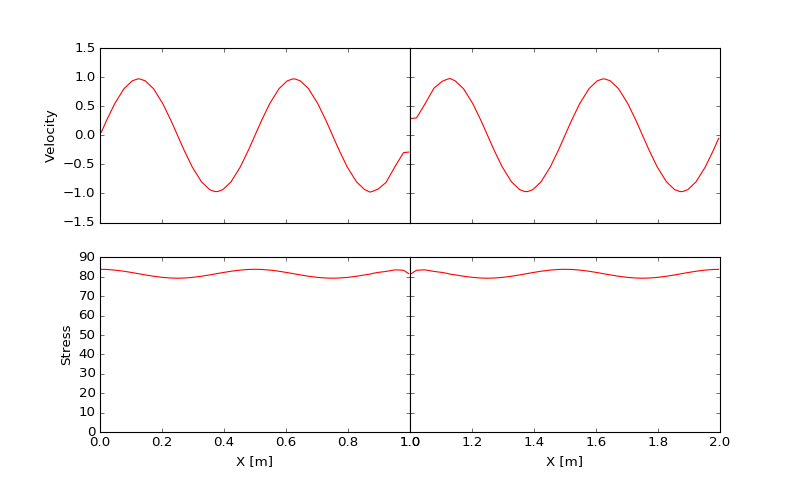

KeyboardInterrupt: 

In [12]:
# Parameters initialization and plotting the simulation

iplot  = 10  

# at the moment, keep the length of the two domain the same
# for the first domain 
ax_1 = 0.0
bx_1 = 1.0

#for the second domain
ax_2 = bx_1
bx_2 = 2.0

NNP = [2,3,4,5,6,12];
ii = 0;
NN = [50,100,200,400,800];
#NN = [50]

#node = 'Lobatto';
node = 'Legendre';

friction_type = 'slip weakening' #choose between linear and slip weakening 

for ii in range(0,5):
    N = NNP[3]
    NP = N+1;
    deg_of_freedom = NN[ii];
    
    num_element = round(deg_of_freedom/NP)
    
    y_1 = np.zeros(NP*num_element)
    y_2 = np.zeros(NP*num_element)
    
    x0_1 = np.linspace(ax_1,bx_1,num_element+1)
    dx_1 = np.diff(x0_1)
    
    x0_2 = np.linspace(ax_2,bx_2,num_element+1)
    dx_2 = np.diff(x0_2)

    if node == 'Legendre':
        GL_return = GL(N)
        psi = GL_return['x']
        w = GL_return['w'];
    if node == 'Lobatto':
        gll_return = gll(N)
        psi = gll_return['xi']
        w = gll_return['weights']
    
    for i in range (1,num_element+1):
        for j in range (1,(N+2)):
            y_1[j+(N+1)*(i-1)-1] = dx_1[i-1]/2.0 * (psi[j-1] + 1.0) +x0_1[i-1]
            y_2[j+(N+1)*(i-1)-1] = dx_2[i-1]/2.0 * (psi[j-1] + 1.0) +x0_2[i-1]
          
    deg_of_freedom = len(y_1) #same for both the domains
    
    D = derivative_GL(N, node)
    
    L_1 = 0.5 * (bx_1-ax_1)
    L_2 = 0.5 * (bx_2-ax_2)
      
    u_1 = np.sin(2*np.pi*y_1/L_1)           # Sine function (multiply by Zero to see the fault behaviour only
    u_2 = np.sin(2*np.pi*y_2/L_2)           # i.e. without wave propagration)
    
    u_1 = np.transpose(u_1)
    v_1 = np.zeros(len(u_1))
   
    u_2 = np.transpose(u_2)
    v_2 = np.zeros(len(u_2))
    #U_2 = np.zeros(len(u_2))
    #V_2 = np.zeros(len(u_2))
    
   
     # Initialize animated plot for u and v    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(10,6))
    line1 = ax1.plot(y_1, u_1,'r')
    line2 = ax2.plot(y_2, u_2,'r')
    line3 = ax3.plot(y_1, v_1,'r')
    line4 = ax4.plot(y_2, v_2,'r')
    
    ax1.set_ylabel('Velocity')
    ax3.set_ylabel('Stress')
    ax3.set_xlabel('X [m]')
    ax4.set_xlabel('X [m]')

    f.subplots_adjust(wspace=0)
    plt.ion()
    plt.show()
    ax1.set_xlim([ax_1, bx_1])
    ax2.set_xlim([ax_2,bx_2])
    
    #parameters, same for both domains (parameters can be different in different domains    
    if friction_type == 'linear': 
        cs = 1;
        rho = 1;
        alpha = 0.5
        Tau_0 = 0                  
    elif friction_type == 'slip weakening':
        cs = 3.464;
        rho = 2.670;
        alpha = 0
        Tau_0 = 81.6                   # initial load (81.24 in Mpa), slight increase will unlock the fault
    
    mu = rho * cs**2;                   
    slip = [] 
    S = 0                             # initial slip (in m)
   
    
    Zs = rho*cs;
    dt = (0.25/(cs*(2*N+1)))*min(dx_1)
    
    #boundary conditions, 0 stands for absorbing boundary, 1 for free surface and -1 for clamped wall 
    r0 = -1; #left boundary
    rn = -1; #right boundary

    t = 0
    c = 0
    
    for t in drange (0.0,10+dt,dt):
        #n = n+1
        ADER_Wave_1D_GL_return = ADER_Wave_1D_GL(u_1,v_1,u_2,v_2,S,D,NP,num_element,dx_1,w,psi,t,r0,rn,dt,rho,mu,alpha)
        u_1 = ADER_Wave_1D_GL_return['Hu_1']
        v_1 = ADER_Wave_1D_GL_return['Hv_1']
        u_2 = ADER_Wave_1D_GL_return['Hu_2']
        v_2 = ADER_Wave_1D_GL_return['Hv_2']
        S   = ADER_Wave_1D_GL_return['H_d']
        slip.append(S)

        if ii % iplot == 0: 
            for l in line1:
                l.remove()
                del l               
            for l in line2:
                l.remove()
                del l 
            for l in line3:
                l.remove()
                del l               
            for l in line4:
                l.remove()
                del l
                
        # Display lines
            line1 = ax1.plot(y_1, u_1, 'r')
            line2 = ax2.plot(y_2, u_2, 'r')
            line3 = ax3.plot(y_1, Tau_0+v_1, 'r')
            line4 = ax4.plot(y_2, Tau_0+v_2, 'r')
        plt.gcf().canvas.draw()  
        
    plt.ioff()
    plt.show() 
    
    plt.figure(2)
    ff = plt.plot(slip)
    plt.ylabel('Slip')
    plt.xlabel('Timesteps')
    plt.show()